_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [9]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [44]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [45]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [46]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [52]:
import re

s = "18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: OBSERVED LIVE FRUIT FLIES IN THE PREP AREA AND DISHWASHING AND HOT WATER TANK AREA. APPROXIMATELY 15 LIVE FRUIT FLIES WERE OBSERVED ON THE WALLS, CEILING AND CEILING TILES, AND EQUIPMENT IN THE PREP AREAS AND DINING ROOM. ADDITIONAL PEST CONTROL SERVICE IS NEEDED TO MINIMIZE OR ELIMINATE THE PEST ACTIVITY.ALL AFFECTED AREAS MUST BE CLEANED AND SANITIZED.  SERIOUS VIOLATION 7-38-020.  | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: DETAIL CLEAN SHELVINGS ABOVE THE 3 COMPARTMENT SINK AND MAINTAIN. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOORS ALONG THE WALLS AND IN ALL CORNERS IN NEED FOR FURTHER CLEANING INCLUDING FLOOR DRAINS AND MAINTAIN. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: REMOVE DUSTS ACCUMULATIONS ON WALLS AND CEILINGS THROUGHOUT THE PREMISES AND MAINTAIN. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: LIGHT SHIELDS ARE MISSING IN BASEMENT AREA WHERE NOTED AND MAINTAIN. | 42. APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN - Comments: MUST PROVIDE HAIR RESTRAINTS FOR FOOD HANDLERS WHEN WORKING AROUND OPEN FOODS INCLUDING MANAGERS AND MAINTAIN. | 43. FOOD (ICE) DISPENSING UTENSILS, WASH CLOTHS PROPERLY STORED - Comments: FOOD ICE SCOOP UTENSIL FOR ICE MACHINE IS BROKEN.INSTRUCTED TO REPLACE AND MAINTAIN.          "

# this is to split to violations column into boolean columns for each individual violation type
# I'm sure there's a more efficient way of doing this but it's what I could come up with in the time constraints
def isVio(num):
    
    def isVio_(s):
        for vio in re.split(r"\|", str(s)):
            m = re.match(r"^\s*(?P<num>\d+)\.", vio)
            if not m:
                continue
            if int(m.group("num")) == num:
                return True
        return False
    
    return isVio_

isVio(18)(s)

True

In [53]:
                              
def wrangle(df):
    
    df = df.copy()
    
    df["Inspection Date"] = pd.to_datetime(df["Inspection Date"])
    
    df["inspection_date_month"] = df["Inspection Date"].dt.month
    df["inspection_date_weekday"] = df["Inspection Date"].dt.weekday
    df["inspection_date_year"] = df["Inspection Date"].dt.year

    for ix in range(75):
        col_name = "vio_" + str(ix)
        df[col_name] = df["Violations"].apply(isVio(ix))
    
    return df

train = wrangle(train)
test = wrangle(test)

In [108]:
from eli5.sklearn import PermutationImportance

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import category_encoders as ce

target = "Fail"
features = train.columns.drop([target] + ["Location", "Inspection Date"])

X_train = train[features].replace({True: 1, False: 0})
y_train = train[target]

X_test = test[features].replace({True: 1, False: 0})
y_test = test[target]

transformer = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
)

X_train_transformed = pd.DataFrame(data=transformer.fit_transform(X_train), columns=features)
X_test_transformed = pd.DataFrame(data=transformer.transform(X_test), columns=features)

model = RandomForestClassifier(n_jobs=-1, n_estimators=120)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring="accuracy",
    n_iter=3,
)

permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [109]:
import eli5

eli5.show_weights(permuter, feature_names=X_train_transformed.columns, top=None)

TypeError: Unexpected feature_names type

In [58]:
# it appears violation is the leak

X_train_transformed.drop(columns=[col for col in features if col.startswith("vio_")] + ["Violations"], inplace=True)
X_test_transformed.drop(columns=[col for col in features if col.startswith("vio_")] + ["Violations"], inplace=True)

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [61]:
pipeline = make_pipeline(
    XGBClassifier(n_jobs=-1, n_estimators=200)
)

In [62]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "xgbclassifier__max_depth": range(5, 75),
    "xgbclassifier__learning_rate": [x/100. for x in range(5, 50, 5)],
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_jobs=-1,
    cv=2,
    n_iter=50,
    verbose=10,
    scoring="accuracy",
)

search.fit(X_train_transformed, y_train)

print("Best params:", search.best_params_)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 32.0min finished


Best params: {'xgbclassifier__max_depth': 14, 'xgbclassifier__learning_rate': 0.05}


In [63]:
print("Best score:", search.best_score_)

Best score: 0.7477656213883966


In [67]:
from sklearn.metrics import roc_auc_score

pipeline = search.best_estimator_
model = pipeline.named_steps["xgbclassifier"]
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

roc_auc_score(y_test, y_pred_proba)

0.7397274930782598

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f67582589b0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6745a39470>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


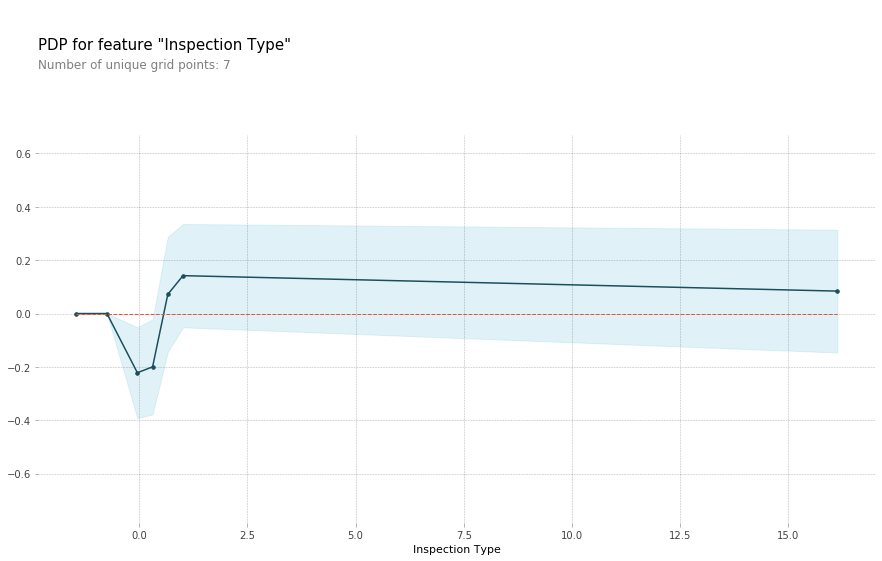

In [77]:
# pdp feature isolation

from pdpbox.pdp import pdp_isolate, pdp_plot

isolate = pdp_isolate(
    model=pipeline,
    dataset=X_test_transformed,
    model_features=X_test_transformed.columns,
    feature="Inspection Type"
)

pdp_plot(isolate, feature_name="Inspection Type")

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f67459ed908>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6745945b38>})

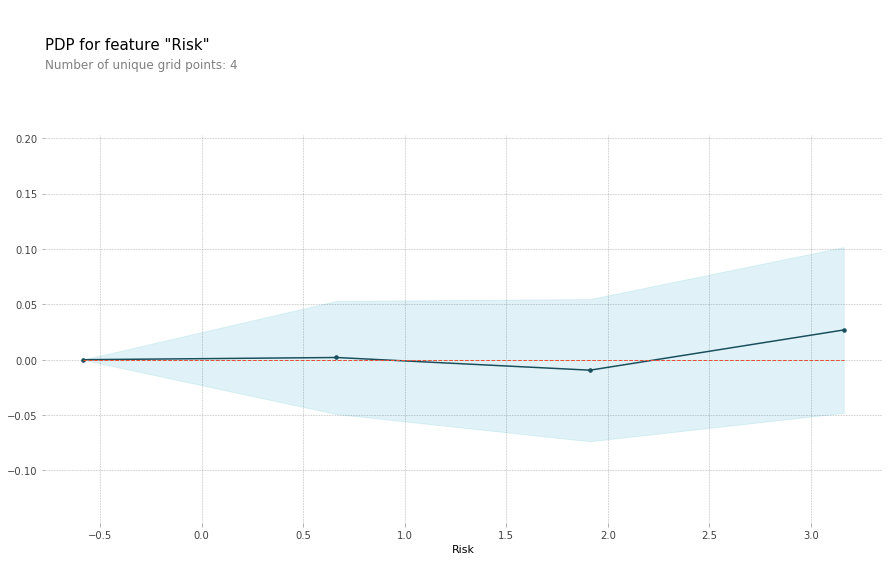

In [81]:
# pdp feature isolation

from pdpbox.pdp import pdp_isolate, pdp_plot

isolate = pdp_isolate(
    model=pipeline,
    dataset=X_test_transformed,
    model_features=X_test_transformed.columns,
    feature="Risk"
)

pdp_plot(isolate, feature_name="Risk")

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f67454bffd0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f674544ca90>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


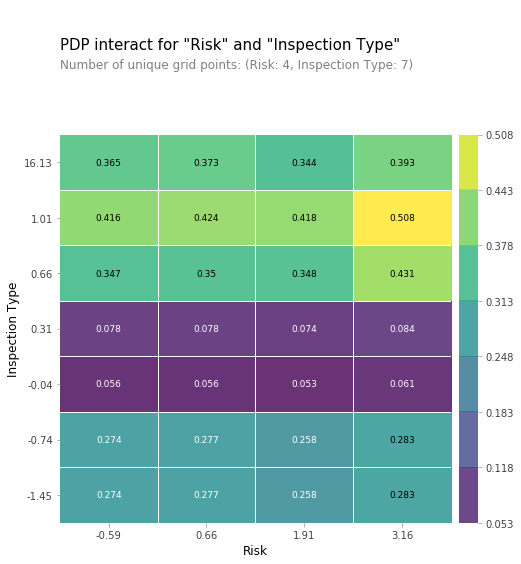

In [101]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ["Risk", "Inspection Type"]
interact = pdp_interact(
    model=pipeline,
    dataset=X_test_transformed,
    model_features=X_test_transformed.columns,
    features=features
)
pdp_interact_plot(interact, feature_names=features, plot_type="grid")

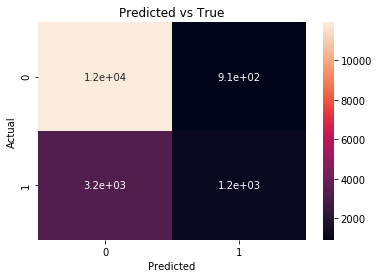

In [74]:
# confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

y_pred = model.predict(X_test_transformed)

matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, ax=ax)
ax.set_title("Predicted vs True")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

fig.show()

In [105]:
# shapley values
from IPython.display import display
import shap

def shapPredict(ix):
    
    row = pd.DataFrame(data=[X_test_transformed.iloc[ix, :]], columns=X_test_transformed.columns)
    display(row)
    y_pred = model.predict(row)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row)
    display(shap_values)
    
    feature_names = X_test_transformed.columns
    values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, values))
    
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[0, :],
        features=row.iloc[0, :]
    )

shapPredict(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Latitude,Longitude,inspection_date_month,inspection_date_weekday,inspection_date_year
1,0.395463,-0.58834,-0.539896,-0.559597,-0.200322,-0.585752,-0.488762,-0.050878,-0.01388,-0.256683,-0.74395,-0.438411,-0.894777,0.783599,-0.778999,0.42876


array([[-0.06748176, -0.00845391, -0.00977402, -0.0787693 , -0.02847502,
         0.01475944, -0.04651448,  0.00019086,  0.        , -0.04701643,
         0.12721874, -0.14772163, -0.05629405,  0.01275622, -0.05584445,
        -0.06496988]], dtype=float32)